# Milestone 1: Advertising

**Business Context:** 

Retail company, "Fashion Haven," operates multiple stores in different cities. The company invests in advertising campaigns to promote its latest collections through various media sources like TV, Newspaper, and Radio. They want to understand the impact of each media source on their sales revenue to optimize their advertising strategy and improve overall business performance.

Currently, Fashion Haven lacks an effective method to predict the sales revenue generated from their advertising efforts accurately. As a result, they struggle to allocate their advertising budget optimally across different media channels, leading to sub optimal returns on investment and inefficient resource allocation.

To address this business problem, Fashion Haven has collected historical data containing information on various advertising campaigns (TV, Newspaper, Radio) and their corresponding sales revenue across their different store locations. The goal is to build a robust predictive model that accurately estimates the sales revenue based on the media sources' advertising budgets, helping the company make data-driven decisions and drive business growth.


Dataset Description:

The data contains the different attributes of the advertising business. The detailed data dictionary is given below.

* TV: Expenditure on media resource- TV 
* Radio: Expenditure on media resource- Radio 
* NewsPaper: Expenditure on media resource- Newspaper 
* Sales: Target Column - Amount of Sales

### ** Connect to the Workspace **  

In [1]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

In [2]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="6793e723-756c-4c5d-84c0-812f1bb4c679", # Subscription ID
    resource_group_name="JuvlinResourceGroup",              # Resource Group
    workspace_name="JuvlinWorkspace",
)

### ** Upload the dataset on Blob Storage as Data Asset **

In [3]:
# Use Data Asset created from File uploaded to Blob Storage
data_asset = ml_client.data.get("advertising_data", version="1")
da_path=data_asset.path								
print(da_path)		

azureml://subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourcegroups/JuvlinResourceGroup/workspaces/JuvlinWorkspace/datastores/workspaceblobstore/paths/UI/2024-11-09_202832_UTC/advertising_raw.csv/


### ** Create a Compute Resource to run the Jobs **

In [4]:
from azure.ai.ml.entities import AmlCompute

# Assign Name to the compute cluster
cpu_compute_target = "cpu-cluster-E2E"

# Define the Azure ML compute object with the intended parameters
cpu_cluster = AmlCompute(
    name=cpu_compute_target,
    type="amlcompute",                 # Azure ML Compute is the on-demand VM service
    size="STANDARD_D2_V3",             # VM Family
    min_instances=0,                   # Minimum running nodes when there is no job running
    max_instances=1,                   # Nodes in cluster
    idle_time_before_scale_down=180,   # How many seconds will the node running after the job termination
    tier="Dedicated",                  # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
)

try:
    cpu_cluster = ml_client.compute.get(cpu_compute_target)  # Check if the compute target already exists
    print(
        f"Compute Cluster {cpu_compute_target} exists, reuse it as is."
    )
except Exception:
    print("Creating a new Compute Cluster...") 
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster).result()   # Pass the object to MLClient's create_or_update method
    print(
    f"AMLCompute Cluster {cpu_cluster.name} created, the compute size is {cpu_cluster.size}"
)

Compute Cluster cpu-cluster-E2E exists, reuse it as is.


### ** Create a Custom Job Environment **

In [5]:
import os

# Name of the directory to create
dependencies_dir = "./env"

# Make directory, if exists don't raise an exception 
os.makedirs(dependencies_dir, exist_ok=True)

** Create YAML File with required dependencies **

-  ** 1. Create and Register the Custom Job Environment in the Workspace. **
-  ** 2. The Environment will be packaged into a Docker Container at runtime. **

In [6]:
%%writefile {dependencies_dir}/conda1.yaml

name: sklearn-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - pip=21.2.4
  - scikit-learn=1.0.2
  - scipy=1.7.1
  - pip:  
    - mlflow==2.8.1
    - azureml-mlflow==1.51.0
    - azureml-inference-server-http
    - azureml-core==1.49.0
    - cloudpickle==1.6.0

Overwriting ./env/conda1.yaml


** Create Environment for ML Tasks **

In [7]:
# Import the Environment Class from the azure.ai.ml.entities module
from azure.ai.ml.entities import Environment


# Name of the Custom Environment to create
custom_env_name = "Milestone1_Project_E2E"

# Create Environment object with the specified properties
job_env = Environment(
    name=custom_env_name,
    description="Custom Environment for ML task",
    conda_file=os.path.join(dependencies_dir, "conda1.yaml"),
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
)
job_env = ml_client.environments.create_or_update(job_env)

# Print information for registered environment
print(
    f"Environment {job_env.name} registered to workspace, the environment version is {job_env.version}"
)

Environment Milestone1_Project_E2E registered to workspace, the environment version is 17


### ** Exploratory Data Analysis **

In [8]:
# Import required Libraries
import argparse
import os
import numpy as np
import pandas as pd
from sklearn import datasets
import mlflow
import mlflow.sklearn

df = pd.read_csv(da_path)

In [9]:
# Parse Features to the correct datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [10]:
# Table Summary
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [11]:
# Display the first 5 record
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [12]:
# Display the last 5 record
df.tail()

,TV,Radio,Newspaper,Sales
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5
199,232.1,8.6,8.7,13.4


In [13]:
# Check for missing values
df.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

** Conclusion: There are no missing or null values **

In [14]:
# Check for all duplicate rows
df[df.duplicated()]

,TV,Radio,Newspaper,Sales


** Conclusion: There are no duplicate records **

### EDA Conclusion: Data is clean and no additional preprocessing is needed ###

### ** Create a Training Script to perform the Training Job **

In [15]:
# Create Directory to store Training Script file
import os

src_dir = "./src"
os.makedirs(src_dir, exist_ok=True)

In [16]:
%%writefile {src_dir}/milestone1_training.py

# Import required Libraries
import argparse
import os
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

import mlflow
import mlflow.sklearn

# Create an argument parser for input arguments from command line
def main():
    parser = argparse.ArgumentParser()

    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument('--criterion', type=str, default='mse', help='measure the quality of a split')
    parser.add_argument('--max-depth', type=int, default=None, help='The maximum depth of the tree.')
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--registered_model_name", type=str, help="model name")

    args = parser.parse_args()

    # Start Logging
    mlflow.start_run()

    # Enable AutoLogging
    # mlflow.sklearn.autolog()

    # Print Input Arguments
    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    # Load Input Data
    print("input data:", args.data)
    df = pd.read_csv(args.data)

    # Log input hyperparameters
    mlflow.log_param('Criterion', str(args.criterion))
    mlflow.log_param('Max depth', str(args.max_depth))

    # Split data into features (X) and target (y)
    X = df[['TV', 'Radio', 'Newspaper']]
    y = df['Sales']
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=args.test_train_ratio, random_state=42)
    
    # Initialize and Train a Decision Tree Regressor

    tree_model = DecisionTreeRegressor(criterion=args.criterion, max_depth=args.max_depth, random_state=42)
    tree_model = tree_model.fit(X_train, y_train)
    tree_predictions = tree_model.predict(X_test)

    # Compute and Log Model for MSE metric
    mse = mean_squared_error(y_test, tree_predictions)
    print(f"Mean Squared Error on test set: {mse}")
    mlflow.log_metric('Mean Squared Error', float(mse))

    # Set Name for the Registered Model
    registered_model_name="milestone1_model"

    # Register Model to the Workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=tree_model,
        registered_model_name=registered_model_name,
        artifact_path=registered_model_name
    )

    # Save Model to a File
    print("Saving the model via MLFlow")
    mlflow.sklearn.save_model(
        sk_model=tree_model,
        path=os.path.join(registered_model_name, 'trained_model'),
    )
   
    # End MLflow tracking
    mlflow.end_run()

if __name__ == '__main__':
    main()


Overwriting ./src/milestone1_training.py


### ** Configure the Training Job **

In [17]:
# Import required Modules

from azure.ai.ml import command
from azure.ai.ml import Input

# Define a new AML job using the Command function
job = command(
    inputs=dict(
        data=Input(
            type="uri_file",           
            path=da_path,                      # Path to the input data file        
        ),
        test_train_ratio=0.3,                  # Ratio of the data to be used for testing
        criterion="mse",                       # Criterion used to measure the quality of a split
        max_depth=2,                           # Maximum depth of the Decision Tree
    ),
    
    code="./src/",                             # Specify Directory containing the code to be run in the job
 
    # Specify command to run in the job, including the input data and parameters as command line arguments
    command="python milestone1_training.py --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}} --criterion ${{inputs.criterion}} --max-depth ${{inputs.max_depth}}",
 
    environment="Milestone1_Project_E2E@latest",     # Specify environment or job
    compute="cpu-cluster-E2E",                       # Specify compute target for job
    experiment_name="train_milestone1_prediction",   # Specify experiment name for job 
    display_name="milestone1_prediction",            # Specify display name for job
)

### ** Run the Training Job **

In [18]:
# Create new Job or update using ml_client.create_or_update
training_job = ml_client.create_or_update(job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


In [19]:
# Wait for the job to complete by streaming logs
ml_client.jobs.stream(training_job.name)

# Proceed with the next steps after the job is complete
print("Job has completed. Proceeding to the next step.")

RunId: frank_soca_x9wb0npxrz
Web View: https://ml.azure.com/runs/frank_soca_x9wb0npxrz?wsid=/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourcegroups/JuvlinResourceGroup/workspaces/JuvlinWorkspace

Execution Summary
RunId: frank_soca_x9wb0npxrz
Web View: https://ml.azure.com/runs/frank_soca_x9wb0npxrz?wsid=/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourcegroups/JuvlinResourceGroup/workspaces/JuvlinWorkspace

Job has completed. Proceeding to the next step.


### ** Define the parameter space for Hyperparameter Tuning **

In [20]:
from azure.ai.ml.sweep import Choice

# Reuse the command_job created 
job_for_sweep = job(
    criterion=Choice(values=["mse"]),
    max_depth=Choice(values=[2, 3, 4, 5]),
)

### ** Configure the Sweep Job for Tuning **

- ** compute ** - specifies the compute target where the sweep job will run.
- ** sampling_algorithm ** - specifies the search algorithm to use for hyperparameter tuning.
- ** primary_metric ** - specifies the metric to optimize during hyperparameter tuning.
- ** goal ** - specifies whether to maximize or minimize the primary metric.
- ** max_total_trials ** - specifies the maximum number of trials to run during hyperparameter tuning.
- ** max_concurrent_trials ** - specifies the maximum number of trials to run concurrently during hyperparameter tuning.

In [21]:
# Configure Sweep Job
sweep_job = job_for_sweep.sweep(
    compute="cpu-cluster-E2E",
    sampling_algorithm="random",
    primary_metric="Mean Squared Error",
    goal="Minimize",
    max_total_trials=4,
    max_concurrent_trials=1,
)

### ** Run the Sweep Job **

In [22]:
# Create or update the Sweep Job
returned_sweep_job = ml_client.create_or_update(sweep_job) 

In [23]:
# Stream the output and wait until the Job is finished
ml_client.jobs.stream(returned_sweep_job.name)

RunId: witty_pummelo_ctlt6zz7rh
Web View: https://ml.azure.com/runs/witty_pummelo_ctlt6zz7rh?wsid=/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourcegroups/JuvlinResourceGroup/workspaces/JuvlinWorkspace

Streaming azureml-logs/hyperdrive.txt

[2024-12-11T18:12:33.9555144Z][GENERATOR][DEBUG]Sampled 1 jobs from search space 
[2024-12-11T18:12:34.3465077Z][SCHEDULER][INFO]Scheduling job, id='witty_pummelo_ctlt6zz7rh_0' 
[2024-12-11T18:12:36.1478399Z][SCHEDULER][INFO]Successfully scheduled a job. Id='witty_pummelo_ctlt6zz7rh_0' 
[2024-12-11T18:13:35.9351862Z][GENERATOR][DEBUG]Sampled 1 jobs from search space 
[2024-12-11T18:13:36.2000464Z][SCHEDULER][INFO]Scheduling job, id='witty_pummelo_ctlt6zz7rh_1' 
[2024-12-11T18:13:36.4670273Z][SCHEDULER][INFO]Successfully scheduled a job. Id='witty_pummelo_ctlt6zz7rh_1' 
[2024-12-11T18:14:38.2007258Z][GENERATOR][DEBUG]Sampled 1 jobs from search space 
[2024-12-11T18:14:38.5515372Z][SCHEDULER][INFO]Scheduling job, id='witty_pummelo_ctlt6zz7r

In [24]:
# Refresh the latest status of the Job after Streaming
returned_sweep_job = ml_client.jobs.get(name=returned_sweep_job.name)

### ** Extract the run that gave Best Modeling results **

In [25]:
# Find the Best Model
from azure.ai.ml.entities import Model

if returned_sweep_job.status == "Completed":

    # Get the run with the best result
    best_run = returned_sweep_job.properties["best_child_run_id"]

    # Get the Model from that run
    model = Model(
        # Stores the Best Model as "milestone1_best_model"
        path="azureml://jobs/{}/outputs/artifacts/paths/milestone1_model/".format(
            best_run
        ),
        name="milestone1_best_model",
        description="Model created from Advertising for Milestone1 Project",
        type="custom_model",
    )

else:
    print(
        "Sweep job status: {}. Please wait until it completes".format(
            returned_sweep_job.status
        )
    )

In [26]:
print(f"Best Model: {model.name}")
print(f"Best Model Path: {model.path}")
print(f"Best Model Type: {model.type}")

Best Model: milestone1_best_model
Best Model Path: azureml://jobs/witty_pummelo_ctlt6zz7rh_1/outputs/artifacts/paths/milestone1_model/
Best Model Type: custom_model


### ** Register the Best Model **

In [27]:
# Register the Best Model
registered_model = ml_client.models.create_or_update(model=model)
print(f"Best Model: {registered_model.name}")
print(f"Best Model Path: {registered_model.path}")

Best Model: milestone1_best_model
Best Model Path: azureml://subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourceGroups/JuvlinResourceGroup/workspaces/JuvlinWorkspace/datastores/workspaceartifactstore/paths/ExperimentRun/dcid.witty_pummelo_ctlt6zz7rh_1/milestone1_model


### ** Configure an Endpoint **

In [28]:
# Import required Libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
from azure.ai.ml.constants import AssetTypes

In [29]:
# Create a unique Endpoint Name
endpoint_suffix = "juvlin"
endpoint_name = "milestone1-endpoint-" + endpoint_suffix
print(f"Endpoint name: {endpoint_name}")

Endpoint name: milestone1-endpoint-juvlin


In [30]:
# Configure the Endpoint
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,   # Unique Endpoint Name within Deployment
    description="An online endpoint serving an MLflow model, for Milestone1 Advertising Prediction task",
                          # A string describing the purpose of the endpoint
    auth_mode="key",      # Authentication mode for endpoint - API key
    tags={"foo": "bar"},  # Dictionary of key-value pairs to tag the Endpoint
)

### ** Create an Endpoint **

In [31]:
# Create the Endpoint
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://milestone1-endpoint-juvlin.eastus2.inference.ml.azure.com/score', 'openapi_uri': 'https://milestone1-endpoint-juvlin.eastus2.inference.ml.azure.com/swagger.json', 'name': 'milestone1-endpoint-juvlin', 'description': 'An online endpoint serving an MLflow model, for Milestone1 Advertising Prediction task', 'tags': {'foo': 'bar'}, 'properties': {'createdBy': 'Juvlin Pinheiro', 'createdAt': '2024-12-11T18:17:58.518637+0000', 'lastModifiedAt': '2024-12-11T18:17:58.518637+0000', 'azureml.onlineendpointid': '/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourcegroups/juvlinresourcegroup/providers/microsoft.machinelearningservices/workspaces/juvlinworkspace/onlineendpoints/milestone1-endpoint-juvlin', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/providers/Microsoft.MachineLearningServices/locations/eastus2/mfe

In [32]:
model_name = "milestone1_best_model"

model = Model(
    name=model_name,
    #The name of the MLflow model.
    path="milestone1_best_model/milestone1_model",
    #Path to the root directory of the model.
    type=AssetTypes.MLFLOW_MODEL,
    #The type of the model asset(MLflow model).
    description="MLflow model for the advertising regression problem",
    #The purpose of the model.
)

### ** Create a Deployment Script to perform Model Deployment **

In [33]:
%%writefile {src_dir}/score.py

# Import necessary libraries and modules
import logging
import os
import json
import mlflow
from io import StringIO
from mlflow.pyfunc.scoring_server import infer_and_parse_json_input, predictions_to_json

######################LOGGER#####################
# Set up Azure logging
import logging
from logging import Logger
from opencensus.ext.azure.log_exporter import AzureLogHandler

# Connect to Application Insights and set logging level to INFO
application_insights_connection_string= 'InstrumentationKey=7854c827-606d-4b69-b4e5-9933d009107d;IngestionEndpoint=https://eastus2-3.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus2.livediagnostics.monitor.azure.com/;ApplicationId=e9fab746-46e7-40c3-b8d0-9735b787df2d'
handler = AzureLogHandler(
connection_string=application_insights_connection_string)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

####################################################

# Define the init() function to load the MLflow model
def init():
    global model
    global input_schema
    # "model" is the path of the mlflow artifacts when the model was registered. For automl
    # models, this is generally "mlflow-model".
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "milestone1_model")
    model = mlflow.pyfunc.load_model(model_path)
    input_schema = model.metadata.get_input_schema()

# Define the run() function to make predictions using the loaded model
def run(raw_data):
    # Parse input data
    json_data = json.loads(raw_data)
    if "input_data" not in json_data.keys():
        raise Exception("Request must contain a top level key named 'input_data'")
    serving_input = json.dumps(json_data["input_data"])
    data = infer_and_parse_json_input(serving_input, input_schema)

    # Make predictions
    predictions = model.predict(data)

    # Log the input data and predictions to Azure
    logger.info("Data:{0},Predictions:{1}".format(str(data),str(predictions)))

    # Convert predictions to JSON format and return
    result = StringIO()
    predictions_to_json(predictions, result)
    return result.getvalue()

Overwriting ./src/score.py


In [34]:
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=endpoint_name,                  # Use the previously generated endpoint name
    model=registered_model,                       # Use the registered model
    environment="Milestone1_Project_E2E@latest",  # Use the latest environment"
    # Use the code in the "./src" directory and the "score.py" script
    code_configuration=CodeConfiguration(
        code="./src", scoring_script="score.py"
    ),
    instance_type="Standard_E2s_v3",              # Use a single instance of type "Standard_E2s_v3"
    instance_count=1,
    app_insights_enabled=True,                    # Enable Application Insights for the deployment
)

In [35]:
# print(f"Model Path: {model_path}")
# print(f"Model Name: {model.name}")

In [36]:
# Deploy the Model to Endpoint
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

..........................................................................

ManagedOnlineDeployment({'private_network_connection': None, 'package_model': False, 'provisioning_state': 'Succeeded', 'endpoint_name': 'milestone1-endpoint-juvlin', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/providers/Microsoft.MachineLearningServices/locations/eastus2/mfeOperationsStatus/odidp:533a1434-a3da-4be8-bff0-922142657211:bd7a68e5-e327-4bbd-b22a-e4bd1a1f74f4?api-version=2023-04-01-preview'}, 'print_as_yaml': False, 'id': '/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourceGroups/JuvlinResourceGroup/providers/Microsoft.MachineLearningServices/workspaces/JuvlinWorkspace/onlineEndpoints/milestone1-endpoint-juvlin/deployments/blue', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/pinhe512611/code/Users/pinhe51261/Code', 'creation_context': <azure.ai.ml._restclient.v2023_04_01_preview

In [37]:
# Print the endpoint and deployment names to verify they are correctly assigned
print("Endpoint Name:", endpoint_name)
print("Deployment Name:", "blue")
# print("Endpoint invocation response:", response)

Endpoint Name: milestone1-endpoint-juvlin
Deployment Name: blue


#### Test the deployment 
Using the MLClient created earlier, we will get a handle to the endpoint. The endpoint can be invoked using the invoke command.

We will send a sample request using a "sample_data.json"file.

In [40]:
model_predictions_azure = ml_client.online_endpoints.invoke(
        endpoint_name=endpoint_name,# Specify the name of the endpoint to invoke
        deployment_name="blue",
        request_file="../src_test/sample-request-sklearn2.json"   # Provide the file containing the sample data for making predictions
)

In [41]:
model_predictions_azure
## Data is "stored" as a string.

'"{\\"predictions\\": [19.566666666666666, 26.0, 19.566666666666666, 14.179999999999998, 17.185714285714287, 19.566666666666666, 26.0, 19.566666666666666, 14.179999999999998, 17.185714285714287, 22.3, 26.0, 22.3, 14.179999999999998, 17.185714285714287, 22.3, 26.0, 24.325, 14.179999999999998]}"'

In [42]:
import ast
ast.literal_eval(model_predictions_azure)

'{"predictions": [19.566666666666666, 26.0, 19.566666666666666, 14.179999999999998, 17.185714285714287, 19.566666666666666, 26.0, 19.566666666666666, 14.179999999999998, 17.185714285714287, 22.3, 26.0, 22.3, 14.179999999999998, 17.185714285714287, 22.3, 26.0, 24.325, 14.179999999999998]}'

In [43]:
# Access the converted Python data structure
import ast
model_predictions_azure_list_2 = ast.literal_eval(ast.literal_eval(model_predictions_azure))
model_predictions_azure_list_2

{'predictions': [19.566666666666666,
  26.0,
  19.566666666666666,
  14.179999999999998,
  17.185714285714287,
  19.566666666666666,
  26.0,
  19.566666666666666,
  14.179999999999998,
  17.185714285714287,
  22.3,
  26.0,
  22.3,
  14.179999999999998,
  17.185714285714287,
  22.3,
  26.0,
  24.325,
  14.179999999999998]}

In [44]:
# Extract the predicted values from the dictionary and convert them to a list or array-like object
predicted_values = model_predictions_azure_list_2['predictions']

##### Target Check
This is a very critical check especially when the ground truth is delayed. By comparing the distribution of the predictions with the target present in the training data, we can flag deviations beyond expected amount of variation.

In [45]:
#Access the training data
import pandas as pd
training_data = pd.read_csv("data/advertising_raw.csv")

In [46]:
training_data.shape

(200, 4)

In [50]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [47]:
pip install seaborn==0.12.2

Note: you may need to restart the kernel to use updated packages.


In [48]:
#General imports required for testing
import json
import ast

import logging

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp, chi2_contingency, ttest_rel

In the plots below, we compare the distribution of predictions from the endpoint logs with the distribution of the target in the training data.

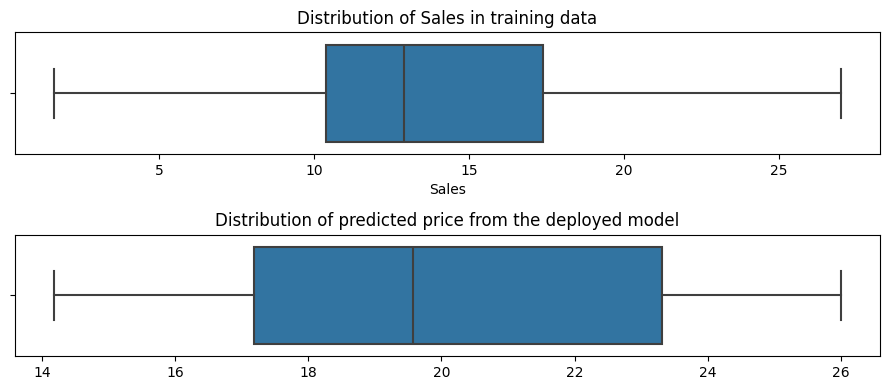

In [51]:
plt.figure(figsize=(9, 4))
plt.subplot(211)
sns.boxplot(x='Sales', data=training_data)
plt.title("Distribution of Sales in training data")
plt.subplot(212)
sns.boxplot(x=predicted_values)
plt.title("Distribution of predicted price from the deployed model")
plt.tight_layout()

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


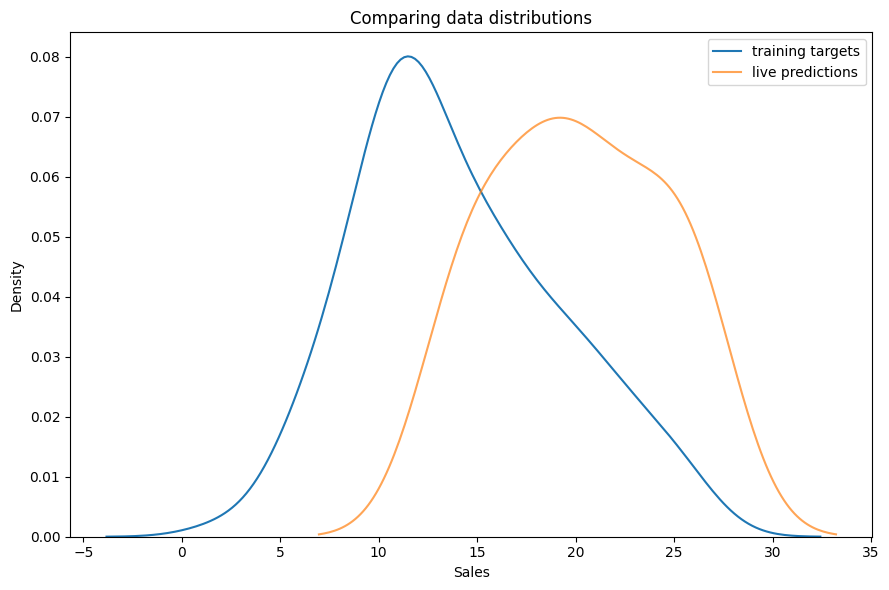

In [52]:
plt.figure(figsize=(9, 6))
sns.kdeplot(x='Sales', data=training_data, label='training targets')
sns.kdeplot(x=predicted_values, label='live predictions', alpha=.7)
plt.legend()
plt.title('Comparing data distributions')
plt.tight_layout()

The plots hint at a difference between the predictions coming from the endpoint and the distribution of targets in the training data.

#### Kolmogorov-Smirnov test

To confirm the absence of target drift, we use the Kolmogorov-Smirnov (K-S) test. K-S test is a statistical method used to compare two probability distributions and determine if they significantly differ from each other. In the context of testing the difference between the distributions of model predictions and the distribution of targets in training data, the K-S test can help assess if there is any deviation or drift.

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


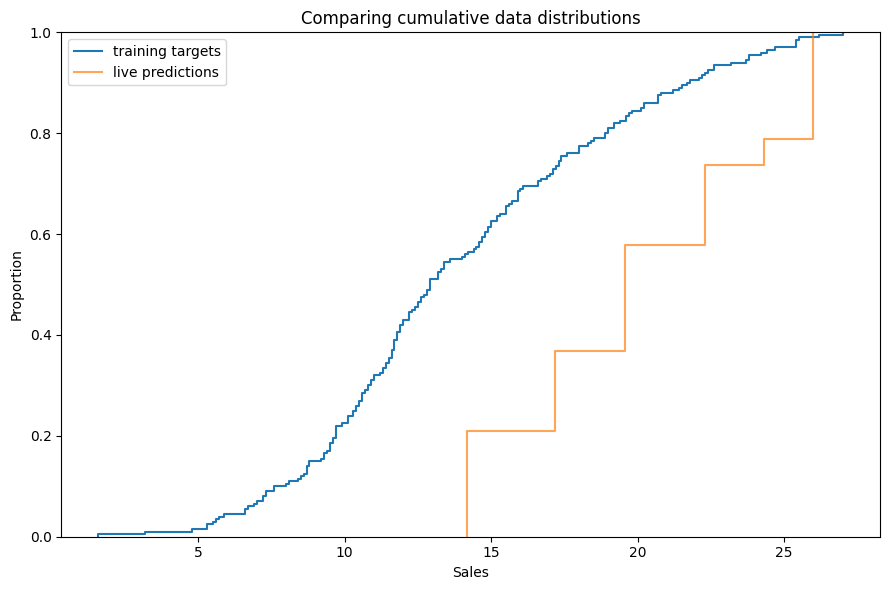

In [53]:
plt.figure(figsize=(9, 6))
sns.ecdfplot(x='Sales', data=training_data, label='training targets')
sns.ecdfplot(x=predicted_values, label='live predictions', alpha=.7)
plt.legend()
plt.title('Comparing cumulative data distributions')
plt.tight_layout()

In [55]:
statistic, p_value = ks_2samp(
            training_data["Sales"].values, 
            predicted_values
)

In [56]:
p_value

1.2109684181133554e-05

Since the p-value is <0.05 , we conclude there is a significant difference between the model predictions and the target distribution in the training data. This means that we will need to focus on those predictions where anomalies are observed and dig deeper into why these deviations were observed. A typical start point is at the outer edges of the predictions to probe why deviations exist.

#### Data Drift
We define data drift as the phenomenon of deviation or changes occurring between the distribution or characteristics of the training features and the corresponding live features used for real-time predictions or analysis. It indicates a shift in the underlying data generating process and can have significant implications for the performance and reliability of machine learning models or data-driven systems.

In [58]:
sample = pd.read_csv("data/advertising_synthetic.csv")

In [59]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         49 non-null     float64
 1   Radio      49 non-null     float64
 2   Newspaper  49 non-null     float64
 3   Sales      49 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


In [60]:
pd.crosstab(training_data['TV'], sample['TV'])

TV,8.6,8.7,13.2,17.2,23.8,25.1,43.1,44.5,57.5,62.3,...,239.9,240.1,248.8,262.9,265.6,266.9,281.4,290.7,292.9,293.6
TV,,,,,,,,,,,,,,,,,,,,,
8.6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8.7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13.2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17.2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23.8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25.1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43.1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44.5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
57.5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
threshold = 0.05
features_with_data_drift = []

In [62]:
target = "Sales"
numeric_features = ['TV', 'Radio', 'Newspaper']
categorical_features = []

In [63]:
for k, feature in enumerate(sample.columns):
    # Check if the feature is numeric
    # Perform the Kolmogorov-Smirnov test between the corresponding feature in the training and sample data
    if feature in numeric_features:
        statistic, p_value = ks_2samp(
            training_data[feature].values, 
            sample[feature].values
        )
        
        if p_value < threshold:
            features_with_data_drift.append(feature)
    # Check if the feature is categorical
    # Perform the chi-squared test between the corresponding feature in the training and sample data
    elif feature in categorical_features:
        statistic, p_value, dof, expected = chi2_contingency(
            pd.crosstab(
                training_data[feature], 
                sample[feature]
            ).values
        )
        # Add the feature to the list of features with data drift
        if p_value < threshold:
            features_with_data_drift.append(feature)

In [64]:
features_with_data_drift

[]

This drift in review_scores_rating is potentially the reason why there is a drift in the predicted targets (e.g., outlier predictions). Once drift is detected, model retraining needs to be executed.

#### Model Drift
To confirm model drift, we compare the ground truth of live data with the predictions from the deployed model. This involves extracting samples where the predictions and ground truth are compared, followed by conducting a statistical test to determine if there is a significant difference between the model predictions and the ground truth.

For regression problems where the ground truth is readily available, we can compare the model's performance on a random sample with the ground truth observed in that sample. This comparison utilizes a paired two-sample t-test since the exact same sample is presented to both the deployed model and the ground truth. If the ground truth is not immediately available, we can estimate it manually and then compare the model's performance on the random sample with the manually estimated ground truth, again employing a paired two-sample t-test. In cases where manual estimation is not possible, we combine the ground truth (when available) with the predictions on the sample and perform a paired two-sample t-test for comparison.


In [66]:
ground_truth_sales = pd.read_csv('data/advertising_ground_truth.csv')

In [67]:
len(ground_truth_sales)

19

In [68]:
ground_truth_sales.tail()

,Sales
14,19.0
15,22.4
16,12.5
17,24.4
18,11.3


In [69]:
# Perform a paired two-sample t-test
two_sample_ttest = ttest_rel(predicted_values, ground_truth_sales['Sales'])

In [70]:
two_sample_ttest.pvalue

0.00023499015130795585

Since the p value is greater than 0.05, we conclude that there is not a significant difference between the model predictions and the ground truth.

#### Inspect Logs for Specific Errors:

In [38]:
# ml_client.online_deployments.get_logs(name="blue", endpoint_name=endpoint_name)

### ** Delete the Endpoint **

**Important!** An Endpoint is a LIVE node which is always running, ready to process & predict to give you output. So unless you are making real-time predictions on streaming data, delete your endpoints after use

In [39]:
# Delete Endpoint
# ml_client.online_endpoints.begin_delete(name=endpoint_name)

### 